In [256]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pickle
import re
import sys
import torch
import tsai.all as tsai
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

sns.set()

sys.path.append('../')

%load_ext autoreload
%autoreload 2
from modules.attributions.attribution_config_dev import config as default_attr_config
from modules.attributions.attribution_processor import ClassificationProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
######## Collect Runtiem Analysis ##########
def maybe_rename(dataset):
    if dataset == 'anomaly_new':
        dataset = 'Anomaly'
    if dataset == 'NonInvasiveFetalECGThorax1':
        dataset = 'NonInvasiveFetalECG'
    return dataset

def extract_runtimes(path):
    runtimes = {}
    with open(path, 'r') as f:
        lines = f.readlines()
    regex = r"Approach: [a-zA-Z]* \| Time: \d*.\d*s"
    regex_d = r"Dataset: [a-zA-Z]*"
    for line in lines:
        # dataset matches
        matches = re.search(regex_d, line)
        if matches:
            dataset = line.replace('Dataset: ', '').strip()
            dataset = maybe_rename(dataset)
        # value matches
        matches = re.search(regex, line)
        if matches:
            approach, runtime = line.split(' | ')
            approach = approach.replace('Approach: ', '')
            runtime = runtime.replace('Time: ', '')[:-2]
            # insert entry
            if not 'GuidedBackprop' in approach and not 'IntegratedGradients' in approach:    
                if dataset not in list(runtimes):
                    runtimes[dataset] ={}
                runtimes[dataset][approach] = float(runtime)
    return runtimes

In [258]:
runtime_file = '../../logs/Runtime_Log.txt'
runtimes = extract_runtimes(runtime_file)
paper_folder = "../results/"

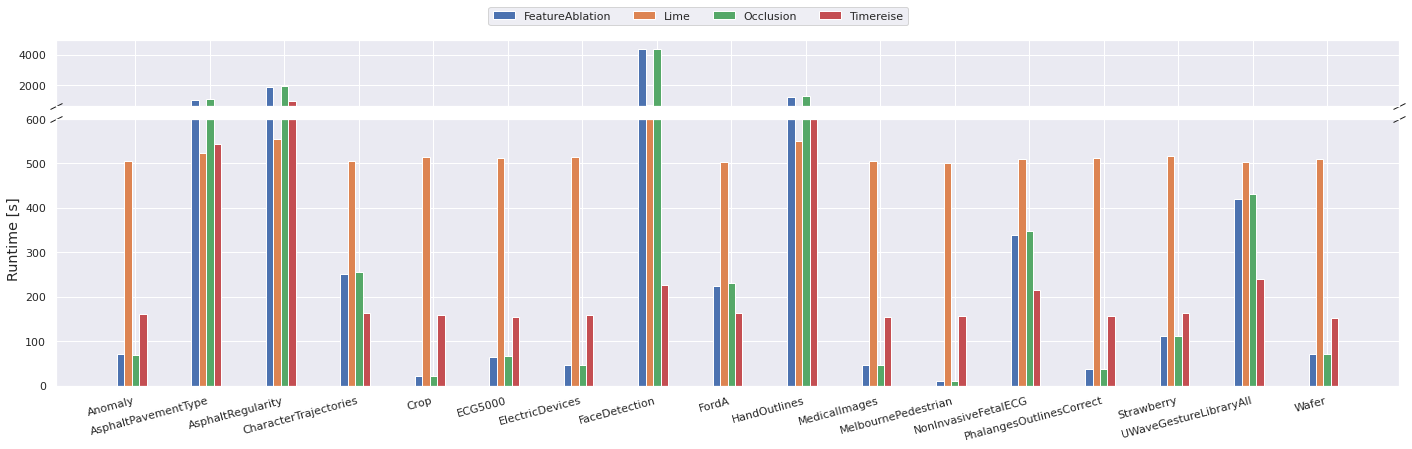

In [259]:
fig, ax = plt.subplots(figsize=(20, 6), nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 4]})
datasets = sorted(runtimes)
methods = sorted(runtimes[datasets[0]])
x = np.arange(len(datasets))
width = 0.1
for i, m in enumerate(methods):
    vals = [runtimes[d][m] for d in datasets]
    off = (i * width) - (width * len(methods) / 2)
    ax[0].bar(x + off, vals, width, label=m)
    for a in ax[1:]:
        a.bar(x + off, vals, width)
      
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
for a in ax[1:-1]:
    a.plot([0, 1], [1, 1], transform=a.transAxes, **kwargs)
    a.plot([0, 1], [0, 0], transform=a.transAxes, **kwargs)
ax[-1].plot([0, 1], [1, 1], transform=ax[-1].transAxes, **kwargs)
        
#ax[0].set_ylim(600, 5000) # outliers only
ax[0].set_ylim(600, 5000) # outliers only
ax[1].set_ylim(0, 600)
fig.supylabel('Runtime [s]')
ax[-1].set_xticks(x, datasets, rotation=15, horizontalalignment='right')
    
fig.legend(loc='upper center', bbox_to_anchor=(.5, 1.05), ncol=len(methods))
plt.tight_layout(h_pad=0.05)

fname = os.path.join(paper_folder, 'Runtime_100.png')
fig.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [166]:
######## Scaling Runtime Analysis ##########
def run_setup(n_samples, timesteps, channels, n_classes):
    dataX = np.random.normal(0, 1, (n_samples, channels, timesteps))
    dataY = np.random.randint(0, n_classes, n_samples)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = tsai.InceptionTime(channels, n_classes).to(device)
    model.eval()

    attrProcessor = ClassificationProcessor(model, dataX.shape[1:], default_attr_config, load=False)
    attrProcessor.compute_all_attributions(dataX, dataY, None)
    return attrProcessor

def execute_settings(settings, save=None):
    result_dict = {}
    for m in sorted(default_attr_config):
        result_dict[m] ={}
    for t, c in tqdm(settings, desc='Number of setups'):
        attrProcessor = run_setup(1, t, c, 2)
        for m in list(attrProcessor.approaches):
            result_dict[m][f'{t}_{c}'] = attrProcessor.approaches[m]['time']
    if save is not None:
        with open(save, 'wb') as f:
            pickle.dump(result_dict, f)
    return result_dict

In [167]:
timesteps = [32, 64, 128, 256, 512, 1024]
channels = [1, 2, 4, 8, 16, 32]
settings = np.array(list(itertools.product(timesteps, channels)))

result_dict = execute_settings(settings, os.path.join(paper_folder, 'Runtimes_1.pickle'))

Number of setups: 100%|██████████| 36/36 [16:34<00:00, 27.63s/it] 


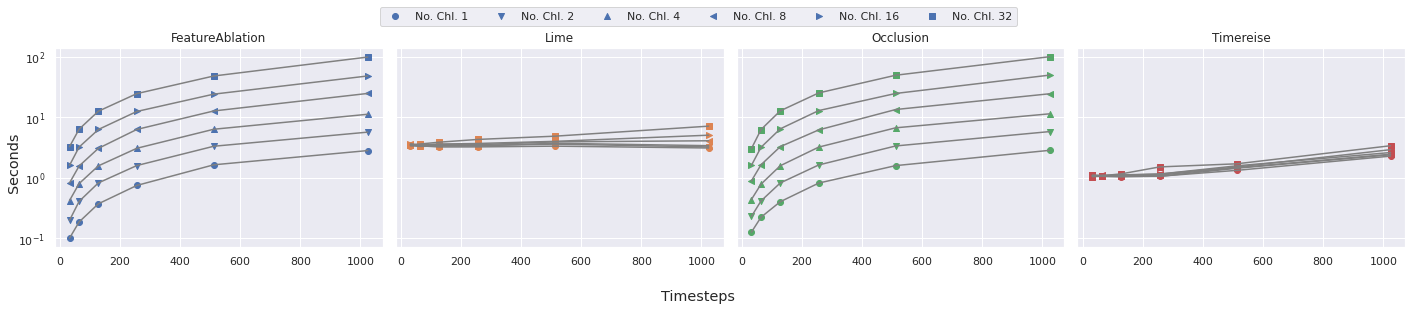

In [255]:
def plot_grid(runtimes, timesteps, channels, save=None):
    fig, ax = plt.subplots(figsize=(20, 4), ncols=len(list(runtimes))-2, sharex=True, sharey=True)
    markers=['o', 'v', '^', '<', '>', 's', 'p']
    methods = [m for m in sorted(runtimes) if 'IntegratedGradients' not in m and 'GuidedBackprop' not in m]
        
    for i, method in enumerate(sorted(methods)):
        for j, chl in enumerate(channels):
            vals = [runtimes[method][f'{t}_{chl}'] for t in timesteps]
            ax[i].set_title(method)
            ax[i].plot(timesteps, vals, c='grey')
            if i == 0:
                #ax[i].set_xscale('log')
                ax[i].set_yscale('log')
                ax[i].scatter(timesteps, vals, marker=markers[j], label=f'No. Chl. {chl}', c=f'C{i}')
            else:
                ax[i].scatter(timesteps, vals, marker=markers[j], c=f'C{i}')
            
    fig.supxlabel('Timesteps')
    fig.supylabel('Seconds')
    fig.legend(loc='upper center', bbox_to_anchor=(.5, 1.06), ncol=len(channels))
    plt.tight_layout()
    
    if save is not None:
        plt.savefig(os.path.join(save, 'Runtimes_1.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
plot_grid(result_dict, timesteps, channels, paper_folder)